In [1]:
import numpy as np
import pandas as pd
import h5py 
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs

In [2]:
henan25 = pd.read_csv('../../Data/points_henan.csv')

henan25['lon'] = henan25['lon'].round(1)
henan25['lat'] = henan25['lat'].round(1)

henan_lon = henan25['lon']
henan_lat = henan25['lat']

lon_true = np.unique(henan25['lon'])
lat_true = np.unique(henan25['lat'])

res = 0.1

nlon, nlat = len(lon_true), len(lat_true)
lon_min, lon_max = lon_true.min(), lon_true.max()
lat_min, lat_max = lat_true.min(), lat_true.max()

target_n = 128

extra_lon = target_n - nlon
extra_lat = target_n - nlat

expand_lon_left = extra_lon // 2
expand_lon_right = extra_lon - expand_lon_left
expand_lat_down = extra_lat // 2
expand_lat_up = extra_lat - expand_lat_down

new_lon_min = (lon_min - expand_lon_left * res).round(1)
new_lon_max = (new_lon_min + (target_n - 1) * res).round(1)
new_lat_min = (lat_min - expand_lat_down * res).round(1)
new_lat_max = (new_lat_min + (target_n - 1) * res).round(1)

lon64 = (np.linspace(new_lon_min, new_lon_max, target_n)).round(1)
lat64 = (np.linspace(new_lat_min, new_lat_max, target_n)).round(1)

lon25 = (np.linspace(-179.9, 180, 3600)).round(1)
lat25 = (np.linspace(-90, 90, 1801)).round(1)

idx_lon25 = np.where((lon25 <= new_lon_max) & (lon25 >= new_lon_min))[0]
idx_lat25 = np.where((lat25 <= new_lat_max) & (lat25 >= new_lat_min))[0]

target_n_1 = 64

lon1 = np.linspace(-179, 180, 360)
lat1 = np.linspace(-90, 90, 181)

idx_lon1 = np.where((lon1 <= new_lon_max) & (lon1 >= new_lon_min))[0]
idx_lat1 = np.where((lat1 <= new_lat_max) & (lat1 >= new_lat_min))[0]


In [3]:
henan_acc_rmse = pd.read_csv('henan_acc_rmse.csv')
saf_acc_rmse = pd.read_csv('SAF_acc_rmse.csv')

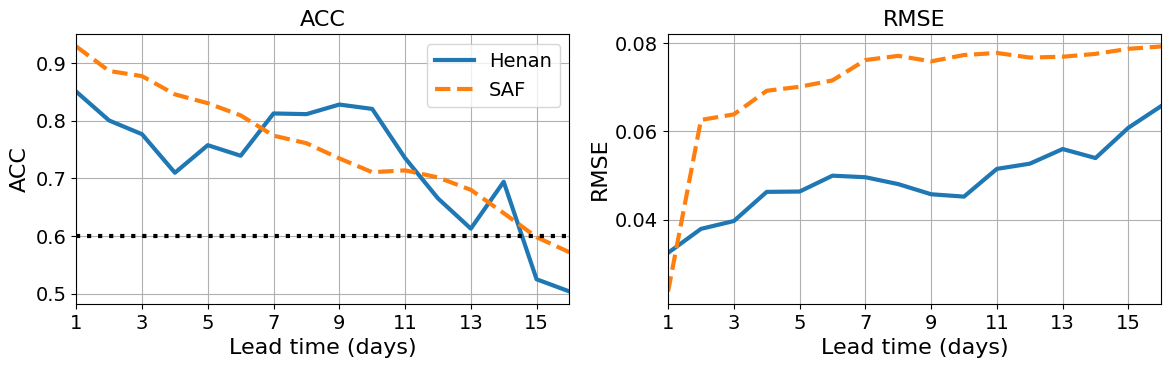

In [4]:

ACC_dict = {}
RMSE_dict = {}

ACC_dict['Henan'] = henan_acc_rmse['ACC']
ACC_dict['SAF'] = saf_acc_rmse['ACC']
RMSE_dict['Henan'] = henan_acc_rmse['RMSE']
RMSE_dict['SAF'] = saf_acc_rmse['RMSE']

names1 = ['Henan', 'SAF']

plt.rcParams.update({
    "font.size": 16,        
    "axes.titlesize": 16,     
    "axes.labelsize": 16,    
    "xtick.labelsize": 14,   
    "ytick.labelsize": 14,  
    "legend.fontsize": 14, 
})

N = len(ACC_dict['Henan'])  
x = np.arange(1, N+1) 

fig, axes = plt.subplots(1, 2, figsize=(14, 3.5)) 

ax = axes[0]
lines = []
for name in names1:
    linestyle = '-' if name == 'Henan' else '--'
    line, = ax.plot(x, ACC_dict[name], label=name, linestyle=linestyle, linewidth=3)
    lines.append(line)

ax.axhline(0.6, color='black', linestyle=':', linewidth=3)

ax.set_xlabel('Lead time (days)')
ax.set_ylabel('ACC')
ax.set_title('ACC')
ax.tick_params(axis='both')
ax.grid(True)
ax.legend(loc='upper right', frameon=True, facecolor='white')
ax.set_xlim(1, N)
ax.set_xticks(np.arange(1, N+1, step=2)) 

ax = axes[1]
for i, name in enumerate(names1):
    linestyle = '-' if name == 'Henan' else '--'
    line, = ax.plot(x, RMSE_dict[name], label=name, linestyle=linestyle, linewidth=3)
    lines.append(line)

ax.set_xlabel('Lead time (days)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE')
ax.tick_params(axis='both')
ax.grid(True)
ax.set_xlim(1, N)
ax.set_xticks(np.arange(1, N+1, step=2)) 

plt.savefig('figure.png', dpi = 300, bbox_inches='tight')
plt.show()


RMSE = 0.053968696446132614


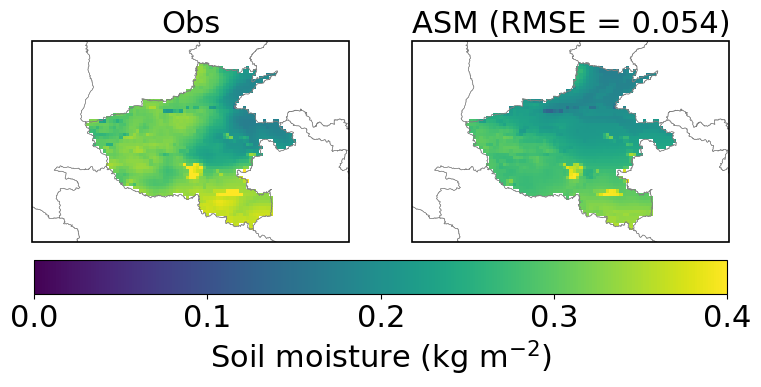

In [5]:
era5_masked = np.load('era5_masked_henan.npy')
preds_masked = np.load('preds_masked_henan.npy')

mask = (~np.isnan(era5_masked)) & (~np.isnan(preds_masked))
rmse = np.sqrt(np.mean((preds_masked[mask] - era5_masked[mask])**2))

print('RMSE =', rmse)

henan_shp = gpd.read_file('../../Data/province/sheng2022.shp').to_crs(epsg=4326)

fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})

im0 = axes[0].imshow(
    era5_masked,
    origin='lower',
    extent=[lon64.min(), lon64.max(), lat64.min(), lat64.max()],
    vmin=0,
    vmax=0.4
)

henan_shp.boundary.plot(
    ax=axes[0],
    linewidth=0.4,
    edgecolor='gray'
)

axes[0].set_xlim(108.77, 118.23)
axes[0].set_ylim(31, 37)
axes[0].set_title('Obs', fontsize=22)

im1 = axes[1].imshow(
    preds_masked,
    origin='lower',
    extent=[lon64.min(), lon64.max(), lat64.min(), lat64.max()],
    vmin=0,
    vmax=0.4
)

henan_shp.boundary.plot(
    ax=axes[1],
    linewidth=0.4,
    edgecolor='gray'
)

axes[1].set_xlim(108.77, 118.23)
axes[1].set_ylim(31, 37)
axes[1].set_title(f'ASM (RMSE = {rmse:.3f})', fontsize = 22)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

cbar = fig.colorbar(
    im0, 
    ax=axes,
    orientation='horizontal',
    fraction=0.10,   
    pad=0.05          
)
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Soil moisture (kg m$^{-2}$)', fontsize=22)

plt.savefig('spatial_henan.png', dpi=300, bbox_inches='tight')
plt.show()